In [1]:
import numpy as np
import mne
import asrpy
from mne.preprocessing import ICA
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict, LeaveOneOut, LeavePOut
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from sklearn.feature_selection import SelectFromModel

# import asrpy
import os

In [49]:

def extract_temporal_features(X):
    """
    Extact mean, std and higher order moments
    """
    features = []
    for epoch in X:
        mean = np.mean(epoch, axis=-1)
        std = np.std(epoch, axis=-1)
        features.append([mean,std])
    return features
def find_gaming_set_files(directory):
    '''Find gaming .set files '''
    # Liste pour stocker les chemins des fichiers correspondants
    matching_files = []

    # Parcourir tous les fichiers dans le répertoire donné
    for root, _, files in os.walk(directory):
        for file in files:
            # Vérifier si le fichier commence par "GAMING" et se termine par ".set"
            if file.startswith("GAMING") and file.endswith(".set"):
                # Ajouter le chemin complet du fichier à la liste
                matching_files.append(os.path.join(root, file))
    
    return matching_files
def Inverse_calculator(epochs , method = 'dSPM'):
    '''Calcul of the inverse operator and apply it on epochs to return source'''
    info = epochs.info

    # Calculer la matrice de covariance de bruit
    noise_cov = mne.compute_covariance(epochs, tmax=0.0, method="auto", rank=None)
    # Utiliser un modèle de tête standard fourni par MNE
    subjects_dir = 'C:/Users/robinaki/mne_data/MNE-sample-data/subjects'


    mne.datasets.fetch_fsaverage(subjects_dir=subjects_dir)
    bem = mne.read_bem_solution(
    'C:/Users/robinaki/mne_data/MNE-sample-data/subjects/fsaverage/bem/fsaverage-5120-5120-5120-bem-sol.fif'
        )
    src = mne.setup_source_space("fsaverage", spacing="oct6", add_dist="patch", subjects_dir=subjects_dir)
    fwd = mne.make_forward_solution(
            info,
            trans="fsaverage",
            src=src,
            bem=bem,
            meg=False,
            eeg=True,
            mindist=5.0,
            n_jobs=None,
            verbose=False,
        )
    # Calculer la solution inverse

    inverse_operator = mne.minimum_norm.make_inverse_operator(info, fwd, noise_cov, loose=0.2, depth=0.8)


    stc= mne.minimum_norm.apply_inverse_epochs(
    epochs,
    inverse_operator,
    lambda2=1.0 / 9.0,
    method=method,
    pick_ori=None,
    verbose=True,
    )
    return stc
def src_data_to_X_data(stc):
    '''extract data from source objects'''
    X_src = []
    for epoch in stc:
        X_src += [epoch.data]
    return X_src
def pre_process_run(raw_fnames ,tmin = -0.5 , tmax = 1 ,f_low = 1, L_H_freq = [(8,30)],Brain_visu = True,baseline = (None, 0),Notchs_freq = (50,60),eeg_reject = 150e-3):
    """ process data in .set format and do source localisation algorithm """
    
    # Initialiser les listes pour les données
    X_all_runs = []
    y_all_runs = []


    reject = dict(eeg=eeg_reject)


    # Charger les fichiers et créer des époques pour chaque run
    N_dir = len(raw_fnames)
    N_freq = len(L_H_freq)

    j = 0
    for raw_fname in raw_fnames:
        raw = mne.io.read_raw_eeglab(raw_fname,preload=True)
        raw.filter( f_low, None)
        raw.notch_filter(Notchs_freq)
        # Appliquer ASR pour nettoyer les artefacts
        # asr = asrpy.ASR(sfreq=raw.info["sfreq"], cutoff=20)
        # asr.fit(raw)
        # raw = asr.transform(raw)
        # ica = ICA()
        # ica.fit(raw)
        # raw= ica.apply(raw)
        X_run = []
        montage = mne.channels.make_standard_montage('standard_1020')
        
        raw.set_montage(montage)
        raw.set_eeg_reference('average', projection=True)

        i = 0
        for l_freq, h_freq in L_H_freq:
        
            print('avancement',i/N_freq,j/N_dir)
            raw2 = raw.copy()
            raw2.filter(l_freq, h_freq)       
            events , event_id= mne.events_from_annotations(raw2)
            event_id_RL= {'right' : event_id['right'] , 'left' : event_id['left']}
            events =mne.pick_events(events, include=[event_id['right'],event_id['left']])
            epochs = mne.Epochs(raw2, events, event_id_RL, tmin, tmax, proj=True, baseline=baseline, reject=reject, preload=True)
            if Brain_visu:
                src = Inverse_calculator(epochs)
                X_src= src_data_to_X_data(src)
                X_run += [X_src]
                del X_src
            else:
                X_run += [epochs.get_data(copy=True)]
            del raw2
            i+=1
        del raw
        j+=1
        X_run = np.moveaxis(X_run, 0, 1)
        y_run = epochs.events[:, -1] == event_id['right']


        X_all_runs.append(X_run)
        y_all_runs.append(y_run)
        del X_run
    return X_all_runs , y_all_runs
def make_featuring(X_features , y_all_runs): 
    '''call extract_temporal_features and reshape the feature in a 2 dim files of size (N_epochs,N_features ) for classification '''
    
    X_ccat = np.moveaxis(X_features,2,0)
    SHAPE = np.shape(X_ccat)
    X_feat_reshaped = np.reshape(X_ccat,(SHAPE[0], SHAPE[1]* SHAPE[2]*SHAPE[3]*SHAPE[4]))
    y = np.concatenate(y_all_runs, axis=0)
    return X_feat_reshaped , y
def Sores_RandomForest(X_train, X_test, y_train, y_test,n_estimators = 100 , model = RandomForestClassifier()):
    selector = SelectFromModel(RandomForestClassifier(n_estimators=n_estimators))
    selector.fit(X_train, y_train)
    X_train_reduced = selector.transform(X_train)
    X_test_reduced = selector.transform(X_test)

    model.fit(X_train_reduced, y_train)
    y_pred = model.predict(X_test_reduced)

    # Evaluation
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.2f}')
    return accuracy 
def Scores_feature_select(X_train, X_test, y_train, y_test ,model_feature_select=PCA(n_components=50),model = RandomForestClassifier()):
    """ Input: Train and test data for training selected classifier with selected features selection
        Output : Accuracy for the test set """

    model_select = model_feature_select

    X_train_select = model_select.fit_transform(X_train,y_train)
    X_test_select = model_select.transform(X_test)

    # Entraîner un modèle de classification avec GradientBoostingClassifier
    model.fit(X_train_select, y_train)

    # Prédire et évaluer le modèle
    y_pred = model.predict(X_test_select)
    accuracy = accuracy_score(y_test, y_pred)

    print(f'Accuracy: {accuracy:.2f}')
    return accuracy
def Scores_no_feature_select(X_train, X_test, y_train, y_test ,model = RandomForestClassifier()):
    """ Input: Train and test data for training selected classifier with no  features selection Output : Accuracy for the test set """
    model.fit(X_train, y_train)
    # Prédire et évaluer le modèle
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.2f}')
    return accuracy

In [6]:
Brain_visu = True
directory_path = "C:/recordings/Game_recordings_test/TOUT_4_second_apple"
raw_fnames = find_gaming_set_files(directory_path)
raw_fnames=['C:/recordings/Game_recordings_test/TOUT_4_second_apple/mergeddata.set']

print(raw_fnames)
X_all_runs , y_all_runs = pre_process_run(raw_fnames)

['C:/recordings/Game_recordings_test/TOUT_4_second_apple/mergeddata.set']
Reading C:\recordings\Game_recordings_test\TOUT_4_second_apple\mergeddata.fdt
Reading 0 ... 809559  =      0.000 ...  3238.236 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upp

C:\Users\robinaki\AppData\Local\Temp\ipykernel_7764\84500236.py:88: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_fname,preload=True)


EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
avancement 0.0 0.0
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 413 samples (1.652 s)

Used Annotations descriptions: ['STOP', 'boundary', 'close-recording', 'left', 'right']
Not setting metadata
706 matching events found
Setting baseline interval to [-0.5, 0.0] s
Applying baseline

In [14]:
X_features = extract_temporal_features(X_all_runs)

In [55]:
X,y = make_featuring(X_features, y_all_runs)

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [2]:
MODEL = [RandomForestClassifier() ,   SVC(), LogisticRegression(max_iter = 1000)]
i= 0
L_PCA=[]
L_RFC =[]
L_no = []
for model in MODEL:
    print(i)
    i+=1
    print('score with PCA')
    L_PCA += [Scores_feature_select(X_train, X_test, y_train, y_test ,model_feature_select=PCA(n_components=50),model=model)]
    print('score with RandomForestClassifier')
    L_RFC += [Sores_RandomForest(X_train, X_test, y_train, y_test ,n_estimators=100,model=model)]
    print('score without feature selection')
    L_no += [Scores_no_feature_select(X_train, X_test, y_train, y_test , model)]


0
score with PCA


NameError: name 'Scores_feature_select' is not defined

In [67]:
L_PCA_range = []
L_PCA_MODEL =[]

for model in MODEL:
    L_PCA_range = []
    for n_components in range(1,120):
        print(n_components)
        print('score with PCA')
        L_PCA += [Scores_feature_select(X_train, X_test, y_train, y_test ,model_feature_select=PCA(n_components=n_components),model=model)]
        print('score with RandomForestClassifier')
        L_RFC += [Sores_RandomForest(X_train, X_test, y_train, y_test ,n_estimators=n_components,model=model)]

1
score with PCA
Accuracy: 0.51
score with RandomForestClassifier
Accuracy: 0.70
2
score with PCA
Accuracy: 0.56
score with RandomForestClassifier
Accuracy: 0.73
3
score with PCA
Accuracy: 0.67
score with RandomForestClassifier
Accuracy: 0.77
4
score with PCA
Accuracy: 0.68
score with RandomForestClassifier
Accuracy: 0.75
5
score with PCA
Accuracy: 0.70
score with RandomForestClassifier
Accuracy: 0.77
6
score with PCA
Accuracy: 0.70
score with RandomForestClassifier
Accuracy: 0.77
7
score with PCA
Accuracy: 0.70
score with RandomForestClassifier
Accuracy: 0.77
8
score with PCA
Accuracy: 0.75
score with RandomForestClassifier
Accuracy: 0.77
9
score with PCA
Accuracy: 0.77
score with RandomForestClassifier
Accuracy: 0.77
10
score with PCA
Accuracy: 0.75
score with RandomForestClassifier
Accuracy: 0.77
11
score with PCA
Accuracy: 0.75
score with RandomForestClassifier
Accuracy: 0.77
12
score with PCA
Accuracy: 0.76
score with RandomForestClassifier
Accuracy: 0.77
13
score with PCA
Accurac

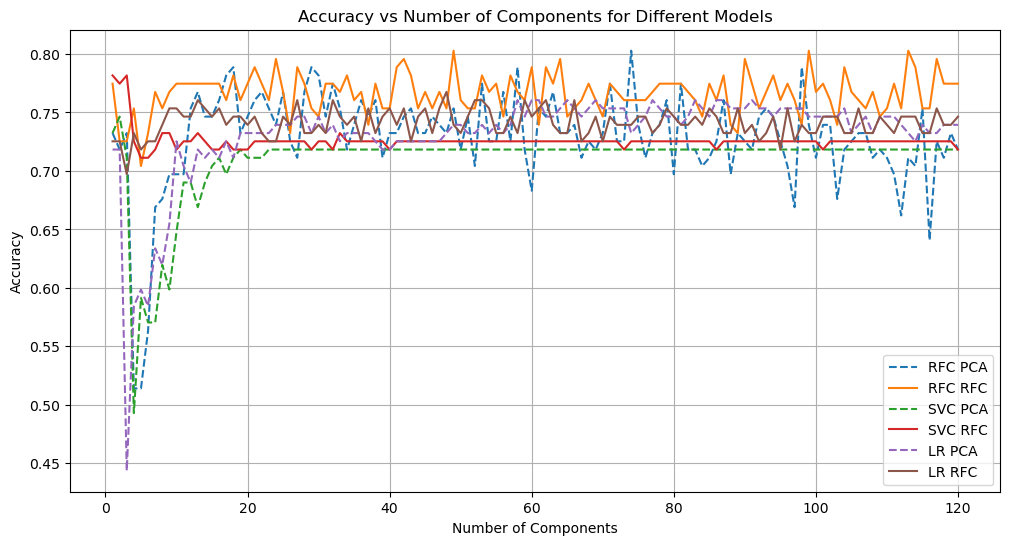

In [86]:
# Les modèles utilisés (modifiez cette liste selon vos modèles)
models = ['RFC', 'SVC', 'LR']

# Nombre maximum de composants
max_n_components = 120

# Simuler des résultats pour l'exemple

# Créer des listes pour stocker les résultats
results = {model: {'N_Components': [], 'PCA_Accuracy': [], 'RFC_Accuracy': []} for model in models}

# Boucler sur les modèles et le nombre de composants
for k in range(len(models)):
    model = models[k]
    for n_components in range(1, max_n_components + 1):
        pca_accuracy = L_PCA[n_components - 1 + k*max_n_components]  # Assurez-vous que L_PCA a suffisamment de valeurs
        rfc_accuracy = L_RFC[n_components - 1+ k*max_n_components]  # Assurez-vous que L_RFC a suffisamment de valeurs
        
        results[model]['N_Components'].append(n_components)
        results[model]['PCA_Accuracy'].append(pca_accuracy)
        results[model]['RFC_Accuracy'].append(rfc_accuracy)

# Tracer les résultats
plt.figure(figsize=(12, 6))

# Tracer les résultats pour chaque modèle
for model in models:
    plt.plot(results[model]['N_Components'], results[model]['PCA_Accuracy'], label=f'{model} PCA', linestyle='--')
    plt.plot(results[model]['N_Components'], results[model]['RFC_Accuracy'], label=f'{model} RFC')

plt.xlabel('Number of Components')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of Components for Different Models')
plt.legend()
plt.grid(True)
plt.show()

In [2]:
# %% Library importation 
import numpy as np
from pylsl import StreamInlet, resolve_stream
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from collections import deque
import pygame
import sys
import random
import time
import logging
import threading
from pythonosc import dispatcher, osc_server
from pylsl import StreamInfo, StreamOutlet
import os
import numpy as np
import mne
import asrpy
import numpy as np
from mne.preprocessing import ICA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict, LeaveOneOut, LeavePOut, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.feature_selection import SelectFromModel
# %% definition of processing data function 

def extract_temporal_features(X):
    """
    Extact mean, std and higher order moments
    """
    features = []
    for epoch in X:
        mean = np.mean(epoch, axis=-1)
        std = np.std(epoch, axis=-1)
        features.append([mean,std])
    return features
def find_gaming_set_files(directory):
    '''Find gaming .set files '''
    # Liste pour stocker les chemins des fichiers correspondants
    matching_files = []

    # Parcourir tous les fichiers dans le répertoire donné
    for root, _, files in os.walk(directory):
        for file in files:
            # Vérifier si le fichier commence par "GAMING" et se termine par ".set"
            if file.startswith("GAMING") and file.endswith(".set"):
                # Ajouter le chemin complet du fichier à la liste
                matching_files.append(os.path.join(root, file))
    
    return matching_files
def Inverse_calculator(info):
    '''Calcul of the inverse operator and apply it on epochs to return source'''

    # Calculer la matrice de covariance de bruit
    noise_cov  = mne.make_ad_hoc_cov(info)
    # Utiliser un modèle de tête standard fourni par MNE
    subjects_dir = 'C:/Users/robinaki/mne_data/MNE-sample-data/subjects'


    mne.datasets.fetch_fsaverage(subjects_dir=subjects_dir)
    bem = mne.read_bem_solution(
    'C:/Users/robinaki/mne_data/MNE-sample-data/subjects/fsaverage/bem/fsaverage-5120-5120-5120-bem-sol.fif'
        )
    src = mne.setup_source_space("fsaverage", spacing="oct6", add_dist="patch", subjects_dir=subjects_dir)
    fwd = mne.make_forward_solution(
            info,
            trans="fsaverage",
            src=src,
            bem=bem,
            meg=False,
            eeg=True,
            mindist=5.0,
            n_jobs=None,
            verbose=False,
        )
    # Calculer la solution inverse

    inverse_operator = mne.minimum_norm.make_inverse_operator(info, fwd, noise_cov, loose=0.2, depth=0.8)
    return inverse_operator
def epochs_to_stc(epochs,inverse_operator,method = 'dSPM'):
    stc= mne.minimum_norm.apply_inverse_epochs(
        epochs,
        inverse_operator,
        lambda2=1.0 / 9.0,
        method=method,
        pick_ori=None,
        verbose=True,
        )
    return stc
def src_data_to_X_data(stc):
    '''extract data from source objects'''
    X_src = []
    for epoch in stc:
        X_src += [epoch.data]
    return X_src
def pre_process_run(raw_fnames ,tmin = -0.5 , tmax = 1 ,f_low = 1, L_H_freq = [(8,30)],Brain_visu = True,baseline = (None, 0),Notchs_freq = (50,60),eeg_reject = 150e-3):
    """ process data in .set format and do source localisation algorithm """
    
    # Initialiser les listes pour les données
    X_all_runs = []
    y_all_runs = []


    reject = dict(eeg=eeg_reject)


    # Charger les fichiers et créer des époques pour chaque run
    N_dir = len(raw_fnames)
    N_freq = len(L_H_freq)

    j = 0
    for raw_fname in raw_fnames:
        raw = mne.io.read_raw_eeglab(raw_fname,preload=True)

        raw.filter( f_low, None)
        raw.notch_filter(Notchs_freq)
        # Appliquer ASR pour nettoyer les artefacts
        # asr = asrpy.ASR(sfreq=raw.info["sfreq"], cutoff=20)
        # asr.fit(raw)
        # raw = asr.transform(raw)
        # ica = ICA()
        # ica.fit(raw)
        # raw= ica.apply(raw)
        X_run = []
        montage = mne.channels.make_standard_montage('standard_1020')
        
        raw.set_montage(montage)
        raw.set_eeg_reference('average', projection=True)

        i = 0
        for l_freq, h_freq in L_H_freq:
            print('avancement',i/N_freq,j/N_dir)
            raw2 = raw.copy()
            raw2.filter(l_freq, h_freq)       
            events , event_id= mne.events_from_annotations(raw2)
            event_id_RL= {'right' : event_id['right'] , 'left' : event_id['left']}
            events =mne.pick_events(events, include=[event_id['right'],event_id['left']])
            epochs = mne.Epochs(raw2, events, event_id_RL, tmin, tmax, proj=True, baseline=baseline, reject=reject, preload=True)
            info = epochs.info
            if Brain_visu:
                inverse_operator = Inverse_calculator(info)
                src = epochs_to_stc(epochs,inverse_operator,method = 'dSPM')
                X_src= src_data_to_X_data(src)
                X_run += [X_src]
                del X_src
            else:
                X_run += [epochs.get_data(copy=True)]
            del raw2
            i+=1
        del raw
        j+=1
        X_run = np.moveaxis(X_run, 0, 1)
        y_run = epochs.events[:, -1] == event_id['right']


        X_all_runs.append(X_run)
        y_all_runs.append(y_run)
        del X_run
    return X_all_runs , y_all_runs, inverse_operator, info
def make_featuring(X_features , y_all_runs): 
    '''call extract_temporal_features and reshape the feature in a 2 dim files of size (N_epochs,N_features ) for classification '''
    
    X_ccat = np.moveaxis(X_features,2,0)
    SHAPE = np.shape(X_ccat)
    X_feat_reshaped = np.reshape(X_ccat,(SHAPE[0], SHAPE[1]* SHAPE[2]*SHAPE[3]*SHAPE[4]))
    y = np.concatenate(y_all_runs, axis=0)
    return X_feat_reshaped , y
def Sores_RandomForest(X_train, X_test, y_train, y_test,n_estimators = 100 , model = RandomForestClassifier()):
    selector = SelectFromModel(RandomForestClassifier(n_estimators=n_estimators))
    selector.fit(X_train, y_train)
    X_train_reduced = selector.transform(X_train)
    X_test_reduced = selector.transform(X_test)

    model.fit(X_train_reduced, y_train)
    y_pred = model.predict(X_test_reduced)

    # Evaluation
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.2f}')
    return accuracy 
def Scores_feature_select(X_train, X_test, y_train, y_test ,model_feature_select=PCA(n_components=50),model = RandomForestClassifier()):
    """ Input: Train and test data for training selected classifier with selected features selection
        Output : Accuracy for the test set """

    model_select = model_feature_select

    X_train_select = model_select.fit_transform(X_train,y_train)
    X_test_select = model_select.transform(X_test)

    # Entraîner un modèle de classification avec GradientBoostingClassifier
    model.fit(X_train_select, y_train)

    # Prédire et évaluer le modèle
    y_pred = model.predict(X_test_select)
    accuracy = accuracy_score(y_test, y_pred)

    print(f'Accuracy: {accuracy:.2f}')
    return accuracy
def Scores_no_feature_select(X_train, X_test, y_train, y_test ,model = RandomForestClassifier()):

    
    """ Input: Train and test data for training selected classifier with no  features selection Output : Accuracy for the test set """
    model.fit(X_train, y_train)
    # Prédire et évaluer le modèle
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.2f}')
    return accuracy

# %% Initializing training data
Brain_visu = True
directory_path = "C:/recordings/Game_recordings_test/TOUT_4_second_apple"
raw_fnames = find_gaming_set_files(directory_path)
raw_fnames=['C:/recordings/Game_recordings_test/TOUT_4_second_apple/mergeddata.set']

X_all_runs , y_all_runs = pre_process_run(raw_fnames)
X_features = extract_temporal_features(X_all_runs)
X,y = make_featuring(X_features, y_all_runs)

def data_to_p(sample,timestamp):
    return random.random()

# %% Initializing game eeg live
 
# Trouver un flux EEG disponible (par exemple, par son type)
print("Recherche d'un flux EEG...")
streams = resolve_stream('name', 'RobinEEG')
inlet = StreamInlet(streams[0],)
info = inlet.info()
n_chan = min(32, info.channel_count())  # Ne traquer que les 32 premiers canaux
description = info.desc()
ch = description.child('channels').first_child()
ch_names = [ch.child_value('label')]
# Receive samples
for i in range(n_chan - 1):
    ch = ch.next_sibling()
    ch_names.append(ch.child_value('label'))

# Logger setup for debugging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
# Absolute path of the current script's directory
script_directory = os.path.dirname(os.path.abspath(__file__))
# Construct the absolute path to 'src/APPLE_GAME'
apple_game_directory = os.path.join(script_directory, '..', 'APPLE_GAME')
# Change the current working directory to 'src/APPLE_GAME'
os.chdir(apple_game_directory)
# Create a new stream for markers
load_time_seconds_before = 2  # Time between each apple drop
load_time_seconds_marker = 1
load_time_seconds = 6
info = StreamInfo('markers', 'Markers', 1, 1/load_time_seconds, 'string', 'MyMarkerStream')
outlet = StreamOutlet(info)
sample,timestamp = inlet.pull_chunk(timeout=1.0)
# Constants
TRAINING_MODE = 2
SCREEN_WIDTH = 400
SCREEN_HEIGHT = 600
PLAYER_WIDTH = 150
PLAYER_HEIGHT = 150
APPLE_SIZE = 80
BACKGROUND_COLOR = (255, 255, 255)
PLAYER_COLOR = (0, 0, 0)
APPLE_COLOR = (255, 0, 0)
LEFT_HAND_OPEN_PATH = "left_hand_open.png"  # Path to the left hand open image
LEFT_HAND_CLOSED_PATH = "left_hand_closed.png"  # Path to the left hand closed image
RIGHT_HAND_OPEN_PATH = "right_hand_open.png"  # Path to the right hand open image
RIGHT_HAND_CLOSED_PATH = "right_hand_closed.png"  # Path to the right hand closed image
APPLE_IMAGE_PATH = "apple.png"  # Path to the apple image
TREE_IMAGE_PATH = "treee.png"
LOAD_BAR_HEIGHT = 20
LOAD_BAR_COLOR = (0, 255, 0)  # Green color for the load bar
MARKER_BAR_COLOR = (255, 128, 0)  # Orange color for the marker line
FPS = 30
raw_fnames=['C:/recordings/Game_recordings_test/TOUT_4_second_apple/mergeddata.set']
training_file = raw_fnames
# Initialize global variable

class Game:
    def __init__(self,PLAYER_HEIGHT,PLAYER_WIDTH,SCREEN_WIDTH,LOAD_BAR_HEIGHT,SCREEN_HEIGHT,APPLE_SIZE,TRAINING_MODE,load_time_seconds_before,load_time_seconds_marker,load_time_seconds):
        pygame.init()
        # definition of pre-processing constant 
        self.time_of_window = 3.3
        self.L_H_freq = [(8,30)]
        self.f_low = 1
        self.Notchs_freq = (50,60)

        self.time_crop = load_time_seconds_marker
        self.model = self.intialize_model(training_file)
        self.ldtb = load_time_seconds_before
        self.ldtm = load_time_seconds_marker
        self.ldt = load_time_seconds
        self.TRAINING_MODE = TRAINING_MODE
        self.screen = pygame.display.set_mode((SCREEN_WIDTH, SCREEN_HEIGHT + LOAD_BAR_HEIGHT))
        pygame.display.set_caption("Apple Catcher Game")
        self.clock = pygame.time.Clock()
        self.font = pygame.font.SysFont(None, 36)
        self.marker_sent = False
        self.player_pos = [SCREEN_WIDTH // 2, SCREEN_HEIGHT - PLAYER_HEIGHT]
        self.apple_pos = [self.get_random_apple_position(), 0]
        self.apple_speed = (SCREEN_HEIGHT -APPLE_SIZE/2  )/ (load_time_seconds * FPS)
        self.score = 0
        self.failures = 0
        self.start_time = time.time()
        self.input_processed= True
        self.tree_image = pygame.image.load(TREE_IMAGE_PATH)
        self.marker_not_finished = True
        self.prob = 0.2
        self.p = 0.5
        # Load and scale images
        self.left_hand_open = pygame.image.load(LEFT_HAND_OPEN_PATH)
        self.left_hand_open = pygame.transform.scale(self.left_hand_open, (PLAYER_WIDTH, PLAYER_HEIGHT))
        self.left_hand_closed = pygame.image.load(LEFT_HAND_CLOSED_PATH)
        self.left_hand_closed = pygame.transform.scale(self.left_hand_closed, (PLAYER_WIDTH, PLAYER_HEIGHT))
        self.right_hand_open = pygame.image.load(RIGHT_HAND_OPEN_PATH)
        self.right_hand_open = pygame.transform.scale(self.right_hand_open, (PLAYER_WIDTH, PLAYER_HEIGHT))
        self.right_hand_closed = pygame.image.load(RIGHT_HAND_CLOSED_PATH)
        self.right_hand_closed = pygame.transform.scale(self.right_hand_closed, (PLAYER_WIDTH, PLAYER_HEIGHT))
        self.apple_image = pygame.image.load(APPLE_IMAGE_PATH)
        self.apple_image = pygame.transform.scale(self.apple_image, (APPLE_SIZE, APPLE_SIZE))

        self.hand_status = {"left": "closed", "right": "closed"}
    def CREATE_EPOCHS(self,events):
        # Assurez-vous que les timestamps et samples ont des formes compatibles
        X_featured = []
        for l_freq, h_freq in self.L_H_freq:
            raw2 = raw.copy()
            raw2.filter(l_freq, h_freq) 
            # Définir les périodes d'intérêt pour couvrir tout le timestamp
            tmin, tmax = 0, self.time_crop # en secondes
            # Créer des epochs
            epochs = mne.epochs(raw2, events, event_id=1, tmin=tmin, tmax=tmax, baseline=(-0.5,0), preload=True)
            src = epochs_to_stc(epochs,inverse_operator,method = 'dSPM')
            X_src = [src_data_to_X_data(src)]
            X_featured +=[extract_temporal_features(X_src)]
        return X_featured
    def pre_process_run_update(self):
        assert self.sample.shape[1] == len(self.timestamp), "Mismatch between samples and timestamps"
        # Convertir les timestamps en secondes (s'ils sont en millisecondes)
        self.events = np.array([[self.timestamp[-1] - self.timestamp[0] - self.time_crop , 0, 1]])  # Un seul événement couvrant tout l'epoch A CHANGER POUR RIGHT ET LEFT
        # Créer un RawArray
        raw = mne.io.RawArray(self.sample, self.info)
        raw.filter( self.f_low, None)
        raw.notch_filter(self.Notchs_freq)
        montage = mne.channels.make_standard_montage('standard_1020')
        
        raw.set_montage(montage)
        raw.set_eeg_reference('average', projection=True)

        epochs = CREATE_EPOCHS(self)
        
        return X_src
    def intialize_model(self, training_file):
        X_all_runs , y_all_runs, self.inverse_operator,self.info = pre_process_run(training_file)
        X_features = extract_temporal_features(X_all_runs)
        X,y = make_featuring(X_features, y_all_runs)
        self.model = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
        # Apprendre de manière incrémentale sur les mini-lots de données
        batch_size = 10
        for i in range(0, len(X_train), batch_size):
            X_batch = X[i:i + batch_size]
            print(np.shape(X_btach))
            y_batch = y[i:i + batch_size]
            self.model.partial_fit(X_batch, y_batch, classes=np.unique(y))
            

    def get_random_apple_position(self):
        return random.choice([SCREEN_WIDTH // 4 - APPLE_SIZE // 2, 3 * SCREEN_WIDTH // 4 - APPLE_SIZE // 2])
    def update_model(self):
        # Apprendre de manière incrémentale sur les mini-lots de données
        X_train = pre_process_run_update(self.timestamp,self.sample,self.inverse_operator,self.info)
        X_train = extract_temporal_features(X_train)
        X_train = X_train.reshape(-1)
        y = 1
        self.model.partial_fit(X_train, y, classes=np.unique(y))
    def draw_player(self):
        if self.hand_status["left"] == "open":
            self.screen.blit(self.left_hand_open, (self.player_pos[0] - PLAYER_WIDTH, self.player_pos[1]))
        else:
            self.screen.blit(self.left_hand_closed, (self.player_pos[0] - PLAYER_WIDTH, self.player_pos[1]))

        if self.hand_status["right"] == "open":
            self.screen.blit(self.right_hand_open, (self.player_pos[0], self.player_pos[1]))
        else:
            self.screen.blit(self.right_hand_closed, (self.player_pos[0], self.player_pos[1]))

    def draw_apple(self):
        self.screen.blit(self.apple_image, (self.apple_pos[0], self.apple_pos[1]))

    def draw_background(self):
        self.screen.blit(self.tree_image, (0, 0))

    def update_apple(self):
        self.apple_pos[1] += self.apple_speed
        if self.apple_pos[1] >= SCREEN_HEIGHT:
            self.apple_pos = [self.get_random_apple_position(), 0]
            self.failures += 1
            self.update_model(self.apple_pos[0] >= SCREEN_WIDTH // 2)
            self.input_processed= True
            self.start_time = time.time()
            self.marker_sent = False
            self.hand_status["left"] = "closed"
            self.hand_status["right"] = "closed"

    def handle_input(self):
        if self.input_processed == False:
            if self.TRAINING_MODE:
                self.prob = int(self.apple_pos[0]/(SCREEN_WIDTH // 2) + 0.5 )
                self.input_processed = True
            if self.TRAINING_MODE==2:
                self.prob = random.choice([int(self.apple_pos[0]/(SCREEN_WIDTH // 2) + 0.5 ),random.random(),int(self.apple_pos[0]/(SCREEN_WIDTH // 2) + 0.5 )])
                self.input_processed = True
            if self.TRAINING_MODE ==  False :
                self.prob = self.p
        if self.prob < 0.5 and self.marker_finished:  # Open left hand
            self.hand_status["left"] = "open"
            self.hand_status["right"] = "closed"
            self.check_catch("left")
        if self.prob >= 0.5 and self.marker_finished:  # Open right hand
            self.hand_status["right"] = "open"
            self.hand_status["left"] = "closed"
            self.check_catch("right")

    def check_catch(self, hand):
        if hand == "left" and self.apple_pos[0] < SCREEN_WIDTH // 2:
            print(self.apple_pos[1] + APPLE_SIZE- self.player_pos[1])
            if self.apple_pos[1]  >= self.player_pos[1]:
                self.score += 1
                self.update_model(0)
                self.hand_status["left"] = "closed"
                self.apple_pos = [self.get_random_apple_position(), 0]
                self.start_time = time.time()
                self.marker_sent = False

        elif hand == "right" and self.apple_pos[0] >= SCREEN_WIDTH // 2:
            if self.apple_pos[1]  >= self.player_pos[1]:
                self.score += 1
                self.update_model(1)
                self.hand_status["right"] = "closed"
                self.apple_pos = [self.get_random_apple_position(), 0]
                self.start_time = time.time()
                self.marker_sent = False
    def draw_scoreboard(self):
        score_text = self.font.render(f'Score: {self.score}', True, (0, 0, 0))
        failures_text = self.font.render(f'Failures: {self.failures}', True, (255, 0, 0))
        self.screen.blit(score_text, (10, 10))
        self.screen.blit(failures_text, (10, 50))

    def draw_load_bar(self):
        elapsed_time = time.time() - self.start_time
        if elapsed_time > self.ldt:
            elapsed_time = self.ldt  # Cap the elapsed time at load_time_seconds

        load_ratio = elapsed_time / self.ldt
        load_bar_width = SCREEN_WIDTH * load_ratio
        load_bar_rect = pygame.Rect(0, SCREEN_HEIGHT, load_bar_width, LOAD_BAR_HEIGHT)
        pygame.draw.rect(self.screen, LOAD_BAR_COLOR, load_bar_rect)

        marker_position = SCREEN_WIDTH * self.ldtb /self.ldt
        marker_position_end = SCREEN_WIDTH * (self.ldtb + self.ldtm)/self.ldt
        marker_rect = pygame.Rect(marker_position, SCREEN_HEIGHT, 2, LOAD_BAR_HEIGHT)
        pygame.draw.rect(self.screen, MARKER_BAR_COLOR, marker_rect)
        marker_rect_end = pygame.Rect(marker_position_end, SCREEN_HEIGHT, 2, LOAD_BAR_HEIGHT)
        pygame.draw.rect(self.screen, MARKER_BAR_COLOR, marker_rect_end)
        if elapsed_time < self.ldtb  and not(self.marker_sent):
            self.marker_not_finished = True
            self.marker_finished = False
        if elapsed_time >= self.ldtb  and not(self.marker_sent):
            if self.apple_pos[0] < SCREEN_WIDTH // 2:
                outlet.push_sample(["left"])
            else:
                outlet.push_sample(["right"])
            self.marker_sent = True
        if elapsed_time >= self.ldtb + self.ldtm  and self.marker_not_finished:
            self.input_processed= False
            self.marker_not_finished = False
            self.sample,self.timestamp = inlet.pull_chunk(timeout=self.time_of_window)
            self.data_to_p()
        if elapsed_time >= self.ldtb + self.ldtm :
            self.marker_finished = True

    def data_to_p(self):
        return random.random()
    def show_menu(self):
        menu_font = pygame.font.SysFont(None, 36)
        title_font = pygame.font.SysFont(None, 54)
        title = title_font.render('Apple Catcher Game', True, (0, 0, 0))
        start_text = menu_font.render('Start Game', True, (0, 0, 0))
        quit_text = menu_font.render('Quit', True, (0, 0, 0))
        
        title_rect = title.get_rect(center=(SCREEN_WIDTH / 2, SCREEN_HEIGHT / 2))
        start_rect = start_text.get_rect(center=(SCREEN_WIDTH / 2, SCREEN_HEIGHT / 2 + 100))
        quit_rect = quit_text.get_rect(center=(SCREEN_WIDTH / 2, SCREEN_HEIGHT / 2 + 150))

        mode_font = pygame.font.SysFont(None, 24)
        mode_0 = mode_font.render('Test', True, (0,0,0))
        mode_1 = mode_font.render('Training', True, (0,0,0))
        mode_2 = mode_font.render('Define', True, (0,0,0))
        mode_0_rect = mode_0.get_rect(center=(SCREEN_WIDTH/4,SCREEN_HEIGHT-100))
        mode_1_rect = mode_1.get_rect(center=(SCREEN_WIDTH/2,SCREEN_HEIGHT-100))
        mode_2_rect = mode_2.get_rect(center=((SCREEN_WIDTH*3)/4,SCREEN_HEIGHT-100))
        
        # Variables
        COULEUR_CHAMP_TEXTE = (200, 200, 200)
        COULEUR_CHAINE = (255, 255, 255)
        COULEUR_BORDURE = (0, 0, 0)
        # Police pour le texte
        imput_font = pygame.font.Font(None, 24)
        chaine_texte = ''
        actif = False
        # Rectangle du champ de texte
        input_rect = pygame.Rect( 275, SCREEN_HEIGHT-70, 50, 32)

        end_value_txt_font = pygame.font.SysFont(None, 24)
        end_value_txt = end_value_txt_font.render('End_Value', True, (0,0,0))
        end_value_txt_rect = end_value_txt.get_rect(center=(((SCREEN_WIDTH*2)/4,SCREEN_HEIGHT-55)))


        while True:
            self.screen.fill(BACKGROUND_COLOR)
            self.draw_background()
            self.screen.blit(title, title_rect)
            self.screen.blit(start_text, start_rect)
            self.screen.blit(quit_text, quit_rect)

            self.screen.blit(mode_0, mode_0_rect)
            self.screen.blit(mode_1, mode_1_rect)
            self.screen.blit(mode_2, mode_2_rect)

            self.screen.blit(end_value_txt, end_value_txt_rect)

            # Dessiner le champ de texte
            pygame.draw.rect(self.screen, COULEUR_CHAMP_TEXTE, input_rect)
            pygame.draw.rect(self.screen, COULEUR_BORDURE, input_rect, 2)
            # Texte à afficher dans le champ de texte
            txt_surface = imput_font.render(chaine_texte, True, COULEUR_CHAINE)
            # Dessiner le texte
            self.screen.blit(txt_surface, (input_rect.x + 5, input_rect.y + 10))

            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    pygame.quit()
                    sys.exit()
                elif event.type == pygame.MOUSEBUTTONDOWN:
                    mouse_pos = pygame.mouse.get_pos()
                    if start_rect.collidepoint(mouse_pos):
                        return 'start'
                    elif quit_rect.collidepoint(mouse_pos):
                        pygame.quit()
                        sys.exit()
                    if mode_0_rect.collidepoint(mouse_pos):
                        self.TRAINING_MODE=False
                        mode_0 = mode_font.render('Test', True, (255,0,0))
                        mode_1 = mode_font.render('Training', True, (0,0,0))
                        mode_2 = mode_font.render('Define', True, (0,0,0))
                    if mode_1_rect.collidepoint(mouse_pos):
                        self.TRAINING_MODE = True
                        mode_0 = mode_font.render('Test', True, (0,0,0))
                        mode_1 = mode_font.render('Training', True, (255,0,0))
                        mode_2 = mode_font.render('Define', True, (0,0,0))                       
                    if mode_2_rect.collidepoint(mouse_pos):
                        self.TRAINING_MODE=2
                        mode_0 = mode_font.render('Test', True, (0,0,0))
                        mode_1 = mode_font.render('Training', True, (0,0,0))
                        mode_2 = mode_font.render('Define', True, (255,0,0))

                    if input_rect.collidepoint(event.pos):
                        actif = not actif
                    else:
                        actif = False

                elif event.type == pygame.KEYDOWN:
                    if actif:
                        if event.key == pygame.K_RETURN:
                            print(chaine_texte)  # Affiche la chaîne entrée dans la console
                            self.end_value=int(chaine_texte)
                            chaine_texte = ''
                        elif event.key == pygame.K_BACKSPACE:
                            chaine_texte = chaine_texte[:-1]
                        else:
                            if event.unicode.isdigit():  # Assure que seuls les chiffres sont entrés
                                chaine_texte += event.unicode


            pygame.display.flip()
            pygame.time.Clock().tick(FPS)

    def run(self):
        running = True
        while running:
            T= time.time()
            if (self.score + self.failures) >= self.end_value:
                outlet.push_sample(['STOP'])
                running = False
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    running = False
            self.screen.fill(BACKGROUND_COLOR)
            self.draw_background()
            self.draw_scoreboard()
            self.draw_load_bar()
            self.handle_input()
            self.update_apple()
            self.draw_player()
            self.draw_apple()
        
            pygame.display.flip()
            print(self.p)
            t = time.time()
            while t-T < 1/FPS:
                t = time.time()


        pygame.quit()
        sys.exit()



if __name__ == "__main__":

    game = Game(PLAYER_HEIGHT,PLAYER_WIDTH,SCREEN_WIDTH,LOAD_BAR_HEIGHT,SCREEN_HEIGHT,APPLE_SIZE,TRAINING_MODE,load_time_seconds_before,load_time_seconds_marker,load_time_seconds)

    if game.show_menu()=='start':
        game.start_time=time.time()
        game.run()

Reading C:\recordings\Game_recordings_test\TOUT_4_second_apple\mergeddata.fdt
Reading 0 ... 809559  =      0.000 ...  3238.236 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



C:\Users\robinaki\AppData\Local\Temp\ipykernel_17664\1406691970.py:118: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_fname,preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
avancement 0.0 0.0
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 

ValueError: too many values to unpack (expected 2)